# Extract Single Date by Polygons
This notebook is designed to iterate through a polygon shapefile and extract image chips based on the fields in the attribute table realting to capture date and sensor mission. This notebook will only extract a bounding rectangle for each shape (incuding multipart shapes rather than an exact polygon).

In [1]:
# What can be deleted here?
%matplotlib inline
import os
import datacube
from datacube import Datacube
from datacube.utils import geometry
from datacube.storage.masking import mask_invalid_data
import fiona
import rasterio.features

import sys
sys.path.append(os.path.abspath('/g/data/r78/DPIPWE_lm/repos/dea-notebooks/Scripts'))
from dea_datahandling import load_ard
from datacube.helpers import write_geotiff
from datacube.drivers.netcdf import write_dataset_to_netcdf

#Specify output directory
outputdir = '/g/data/r78/DPIPWE_lm/output_data/'
if not os.path.exists(outputdir):
    print("output directory doesn't exist")
    exit()

In [2]:
# This section is included so that the load_ard function can be used.
# Connect to datacube containing Landsat data
dc_sentinel2 = datacube.Datacube(app='Using_load_ard')


# Temporary solution to account for Collection 3 data being in a different
# database on the NCI
try:
    dc_landsat = datacube.Datacube(app='Using_load_ard', env='c3-samples') # need access to project xu18 for ard
except:
    dc_landsat = datacube.Datacube(app='Using_load_ard')

#dc = datacube.Datacube(app='load_landsat_example')

In [3]:
# Set this to the location for the polygon shapefile (must contain appropriate attributes)
shape_file = os.path.expanduser('/g/data1a/r78/DPIPWE_lm/input_data/DEA_multi__sen_shapes.shp')

In [4]:
# This function masks data based on a feature geometry

def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    return rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

In [24]:
# Use Fiona to iterate through polgons in shapefile and export image chips to geotiff
# NB Multipart geometries will result in total combined extent being extracted
with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        for shape in shapes:
            
            geom = geometry.Geometry(shape['geometry'], crs=crs)
            sen = (shape['properties']['SENSOR'])
            #sdate = (shape['properties']['SEN_DATE'])
            #sdate = str(sdate)
            ds_name = (shape['properties']['NAME'])+'_'+(shape['properties']['SENSOR']) #make a name for each ds
            #print(sdate)
            
            query = {'geopolygon': geom,
                     #'time': (sdate),
                     'time': ('2018-11-15', '2018-12-31'), # Define temporal period for multi date case
                     'group_by': 'solar_day',
                     'output_crs':crs}
            
            #print(sen)
            
            if sen == 'SENTINEL':
                # Load available data from both Sentinel 2 satellites
                ds = load_ard(dc=dc_sentinel2,
                    products=['s2a_ard_granule', 's2b_ard_granule'],
                    measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1'],
                    resolution=(-20, 20),
                    **query)

            elif sen == 'LANDSAT':
                ds = load_ard(dc=dc_landsat,
                    products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
                    measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1'],
                    resolution=(-30, 30),
                    **query)

            else:
                print('Sensor not recognised. No data loaded')
                
                
            ds = mask_invalid_data(ds) # sets all 'nodata' to 'nan'
            
            mask = geometry_mask([geom], ds.geobox, invert=True)
            ds = ds.where(mask)
            
            print(ds_name)

            # Print output data
            #print(ds)
            
            # Choose the most appropriate block below for what you wish to export
            
            '''
            # This block will export to NetCDF (will bundle layers with time slices)
            chip = ds_name + '.nc' # NB some names may have spaces
            print('Writing image '+ chip)
            write_dataset_to_netcdf(ds, outputdir + chip)
            '''
            '''
            # If exporting to Geotiff a single time slice will need to be specified
            # Write multi-band GeoTIFF to a location
            chip = ds_name + '.tif' # NB some names may have spaces 
            print('Writing image '+chip)
            write_geotiff(outputdir + chip, ds.isel(time=0)) #Not sure why time slice is needed?
            '''
            '''
            #This block will iterate through cube and export a multiband image
            #for each time slice
            for i in range(len(ds.time)):
                # Use the date of the satellite image to name Geotiff
                date = str(ds.isel(time=i).time.data)[:-19]
                print(f'Writing {date}')
                
                #Write GeoTIFF
                write_geotiff(outputdir + ds_name + '_' + f'{date}.tif', ds.isel(time=i))
            '''
            

Loading s2a_ard_granule data
    Applying pixel quality mask
Loading s2b_ard_granule data
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 19 observations 
Jilletts Tier_SENTINEL
Writing 2018-11-16
Writing 2018-11-19
Writing 2018-11-21
Writing 2018-11-24
Writing 2018-11-26
Writing 2018-11-29
Writing 2018-12-01
Writing 2018-12-04
Writing 2018-12-06
Writing 2018-12-09
Writing 2018-12-11
Writing 2018-12-14
Writing 2018-12-16
Writing 2018-12-19
Writing 2018-12-21
Writing 2018-12-24
Writing 2018-12-26
Writing 2018-12-29
Writing 2018-12-31
Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Applying pixel quality mask
Loading ga_ls8c_ard_3 data
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 6 observations 
Boobyalla_LANDSAT
Writing 2018-11-18
Writing 2018-11-26
Writing 2018-12-04
Writing 2018-12-12
Writing 2018-12-20
Writing 2018-12-28
Loading s2a_ard_gr

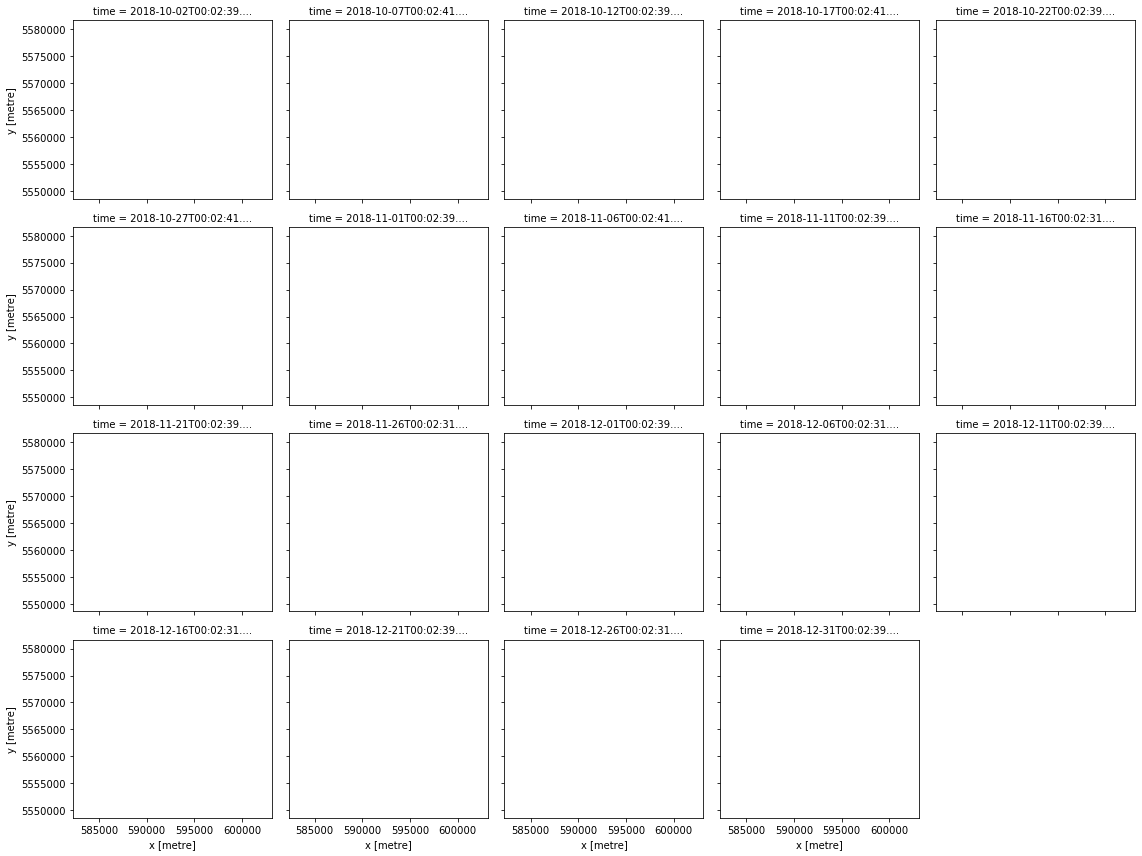

In [13]:
# Plot the last ds time series
fake_saturation = 80
rgb = ds.to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
rgb /= fake_saturation  # scale to [0, 1] range for imshow

rgb.plot.imshow(x=ds.crs.dimensions[1], y=ds.crs.dimensions[0],
                col='time', col_wrap=5, add_colorbar=False)